# Анализ данных А/B теста, проведенного крупным интернет-магазином с целью увеличения выручки

## Введение

Для проекта представлены данные A/B-теста, проведенного крупным интернет-магазином. Заказчик предпочел не публиковать суть тестируемой гипотезы.

Тест проходил на протяжении месяца - августа 2019г. Пользователи поделены на две группы - А и В.


Цель работы - проанализировать результаты проведенного A/B-теста: как в разных группах ведут себя показатели среднего чека и среднего количества заказов. На основе полученных результатов сделать выводы об успешности теста, стоит ли его продолжать или остановить.

Описание входных данных:

* orders.csv, visitors.csv - в файлах описаны результаты проведенного A/B-теста, информация о заказах и посетителях, разделенных на 2 группы

План работы:

* Провести предобработку данных
* Выполнить анализ графиков с разбивкой по группам, которые характеризуют изменения кумулятивной выручки, кумулятивного среднего чека, среднего количества заказов на посетителя, стоимостей заказов
* Определить выбивающиеся значения стоимости заказов и количества заказов на одного пользователя, которые использовать в дальнейшем для фильтрации данных

Проверить нулевые и альтернативные гипотезы, выполнить расчет статистической значимости различий:
* Нулевая гипотеза: различий в среднем количестве заказов на посетителя между группами нет. Альтернативная: различия в среднем между группами есть.
* Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная: различия в среднем чеке между группами есть.

Рассчитать статистическую значимость для следующих вариантов данных: 
* сырых
* фильтрованных от выбросов
* сырых с исключением пользователей, попавших в обе группы данных
* фильтрованных от выбросов и исключением пользователей, попавших в обе группы данных

Сделать выводы об успешности теста и целесообразности его остановки/продолжения


## Загрузка данных и подготовка их к анализу

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
import warnings

In [2]:
# импорт данных
orders = pd.read_csv(
    'C:/DataAnalysis/initial_data/project_8/orders.csv') 
visitors = pd.read_csv(
    'C:/DataAnalysis/initial_data/project_8/visitors.csv')

In [3]:
display(orders.info())
display(orders.head());

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [4]:
display(visitors.info())
display(visitors.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Столбцам, отвечающим за дату необходимо изменить тип данных с object на datetime

## 1. Предобработка данных и подготовка их к анализу

### 1.1. Преобразование типов данных в столбцах

In [5]:
# преобразование столбцов дат в нужный формат
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

### 1.2. Определение временного промежутка исследования

In [6]:
print(f'1й заказ: {orders["date"].min().date()}, последний заказ: {orders["date"].max().date()}') 
print(f'1й посетитель: {visitors["date"].min().date()}, последний посетитель: {visitors["date"].max().date()}') 

1й заказ: 2019-08-01, последний заказ: 2019-08-31
1й посетитель: 2019-08-01, последний посетитель: 2019-08-31


### 1.3. Обработка пропусков

In [7]:
display(orders.isna().sum().sort_values(ascending=False))
display(visitors.isna().sum().sort_values(ascending=False))

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

date        0
group       0
visitors    0
dtype: int64

Пропуски в данных отсутствуют

### 1.4. Обработка дубликатов

In [8]:
# поиск явных дубликатов
display(orders.duplicated().value_counts())
display(visitors.duplicated().value_counts())

False    1197
dtype: int64

False    62
dtype: int64

Явных дубликатов в данных нет. Проверим, корректно ли агрегированы посетители по дням - нет ли нескольких строк, которые относятся к одному дню и одной группе 


In [9]:
visitors[['date','group']].duplicated().value_counts()

False    62
dtype: int64

### 1.5. Проверка входных параметров А/В теста

##### Условие: попавший в одну из групп посетитель остаётся в этой группе до конца теста

Проверка, есть ли пользователи, которые на протяжении исследования входили не только в одну группу

In [10]:
# отображение уникальных пар "пользователь-группа"
unique_visitors = orders[['group','visitorId']].drop_duplicates()
print(f'Общее число пользователей А/В теста: {unique_visitors["visitorId"].count()}')

# поиск пользователей, чье имя встречается и для группы А, и для группы В
double_users = unique_visitors['visitorId'].value_counts() 
double_users = double_users[double_users>1]

print(f'Общее число пользователей, попавших в обе группы: {double_users.count()}')

Общее число пользователей А/В теста: 1089
Общее число пользователей, попавших в обе группы: 58


Согласно данным выше, имеем 58 пользователей, которые попали в обе группы.

При дальнейшей оценке различных показателей будем рассматривать их в разрезе полного количества пользователей и удаления "дублеров"

In [11]:
# оставим в double_users только номера пользователей и создадим список с номерами
double_users = double_users.reset_index()
double_users = double_users[['index']]
double_users_list = double_users['index'].tolist()

# оставим серию только с номерами пользователей
double_users = double_users.reset_index()
double_users = double_users['index']

# отфильтруем датафрейм с заказами, исключая пользователей, входящих в обе группы 
orders_cut = orders.query('visitorId not in @double_users_list')

# посчитаем, как изменилось количество строк после удаления операций дублеров 
print(orders.count() - orders_cut.count())


transactionId    181
visitorId        181
date             181
revenue          181
group            181
dtype: int64


В результате фильтрации удалена 181 строка. Таким образом, имеем 58 удаленных пользователей, которые совершили 181 транзакцию.

Отобразим для ознакомления первые 10 строк, которые были удалены.



In [12]:
orders.query('visitorId in @double_users_list').sort_values(by = 'visitorId').head(10)

,transactionId,visitorId,date,revenue,group
703,4293855558,8300375,2019-08-07,1790,A
71,3679129301,8300375,2019-08-01,10510,B
823,2971973105,199603092,2019-08-27,2790,A
246,437656952,199603092,2019-08-02,3488,B
26,2223239646,199603092,2019-08-15,3488,A
134,62794304,199603092,2019-08-22,6976,A
1102,1941707234,199603092,2019-08-12,6438,A
1009,2670069237,232979603,2019-08-31,2640,B
1013,83566152,232979603,2019-08-31,60,A
590,3702128013,237748145,2019-08-20,1290,A


## 2. Анализ A/B-теста

### 2.1 График кумулятивной выручки по группам

**Работа с датафреймом без фильтрации пользователей, попавших в обе группы**

Сформируем общий датафрейм с разбивкой по датам-группам, указанием кол-ва уникальных покупателей, уникальных операций и суммы выручки, а также общего числа посетителей

In [13]:
# агрегация данных по дням-группам из таблицы orders
orders_aggregated = orders.pivot_table(index = {'date','group'}, values = {'transactionId','visitorId', 'revenue'},\
                                       aggfunc = {'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'})
orders_aggregated = orders_aggregated.reset_index()
orders_aggregated.head(5)

,group,date,revenue,transactionId,visitorId
0,A,2019-08-01,148579,24,20
1,A,2019-08-02,93822,20,19
2,A,2019-08-03,112473,24,24
3,A,2019-08-04,70825,16,15
4,A,2019-08-05,124218,25,25


In [14]:
# слияние orders_aggregated и таблицы visitors
cumulative_data = orders_aggregated.merge(visitors, left_on=['date', 'group'], right_on=['date', 'group'])

cumulative_data.columns = ['date', 'group', 'revenue', 'orders', 'buyers', 'visitors']
cumulative_data.head()

,date,group,revenue,orders,buyers,visitors
0,A,2019-08-01,148579,24,20,719
1,A,2019-08-02,93822,20,19,619
2,A,2019-08-03,112473,24,24,507
3,A,2019-08-04,70825,16,15,717
4,A,2019-08-05,124218,25,25,756


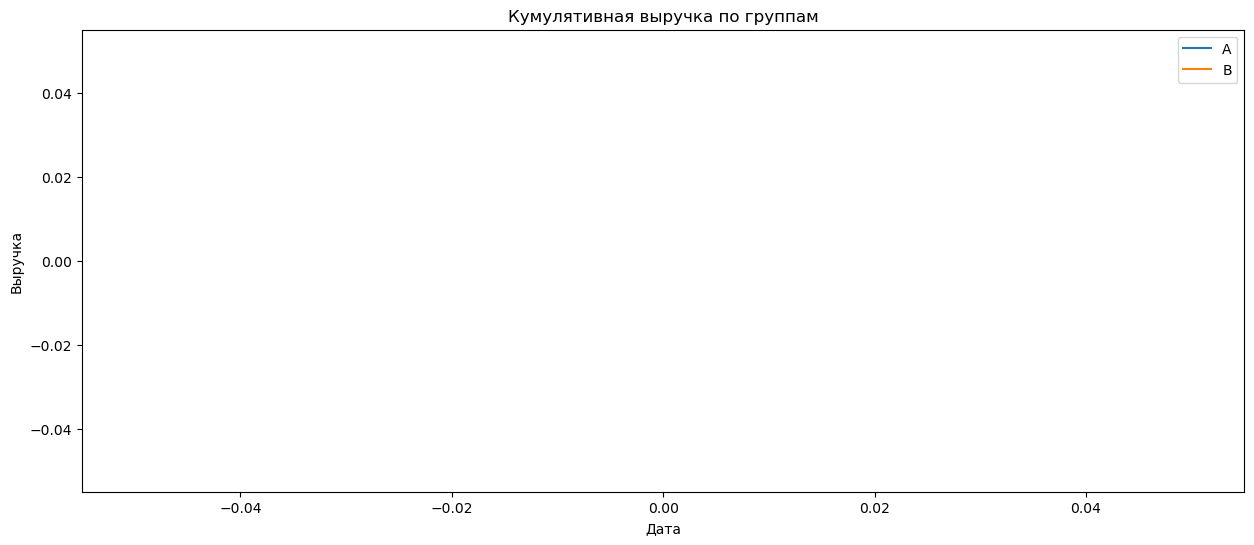

In [15]:
cumulative_data_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_data_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# преобразуем серии с суммой выручки и заказов в накопленную сумму
cumulative_data_A[['revenue', 'orders']] = cumulative_data_A[['revenue', 'orders']].apply(lambda x: x.cumsum(), axis=0) 
cumulative_data_B[['revenue', 'orders']] = cumulative_data_B[['revenue', 'orders']].apply(lambda x: x.cumsum(), axis=0) 

plt.figure(figsize=(15, 6))
plt.plot(cumulative_data_A['date'], cumulative_data_A['revenue'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['revenue'], label='B')

plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend()
plt.title('Кумулятивная выручка по группам'); 

**Работа с датафреймом с фильтрации пользователей, попавших в обе группы**

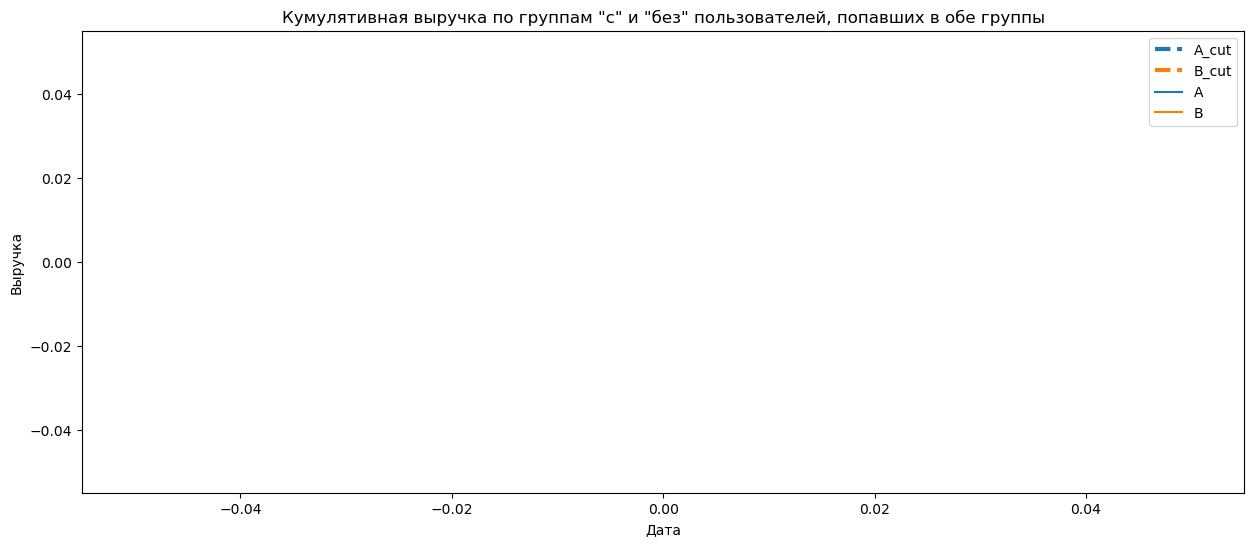

In [16]:
# агрегация данных по дням-группам из таблицы orders
orders_cut_aggregated = orders_cut.pivot_table(index = {'date','group'}, values = {'transactionId','visitorId', 'revenue'},\
                                       aggfunc = {'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'})
orders_cut_aggregated = orders_cut_aggregated.reset_index()

# слияние orders_aggregated и таблицы visitors
cumulative_data_cut = orders_cut_aggregated.merge(visitors, left_on=['date', 'group'], right_on=['date', 'group'])

cumulative_data_cut.columns = ['date', 'group', 'revenue', 'orders', 'buyers', 'visitors']
cumulative_data_cut.head()

cumulative_data_A_cut = cumulative_data_cut[cumulative_data_cut['group']=='A'][['date','revenue', 'orders']]
cumulative_data_B_cut = cumulative_data_cut[cumulative_data_cut['group']=='B'][['date','revenue', 'orders']]

# преобразуем серии с суммой выручки и заказов в накопленную сумму
cumulative_data_A_cut[['revenue', 'orders']] = cumulative_data_A_cut[['revenue', 'orders']].apply(lambda x: x.cumsum(), axis=0) 
cumulative_data_B_cut[['revenue', 'orders']] = cumulative_data_B_cut[['revenue', 'orders']].apply(lambda x: x.cumsum(), axis=0) 

plt.figure(figsize=(15, 6))
plt.plot(cumulative_data_A_cut['date'], cumulative_data_A_cut['revenue'], label='A_cut', linestyle='dashed', linewidth = 3)
plt.plot(cumulative_data_B_cut['date'], cumulative_data_B_cut['revenue'], label='B_cut', linestyle='dashed', linewidth = 3)

plt.plot(cumulative_data_A['date'], cumulative_data_A['revenue'], label='A', color='C0')
plt.plot(cumulative_data_B['date'], cumulative_data_B['revenue'], label='B', color='C1')

plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend()
plt.title('Кумулятивная выручка по группам "с" и "без" пользователей, попавших в обе группы'); 

Накопленная выручка группы В на протяжении всего времени исследования превышает показатель группы А. При этом, между 17 и 21 августа происходит резкий скачок выручки у группы В, что вероятно может быть связано с единичной крупной покупкой, так и с резким ростом конверсии посетителей группы В из посетителей в покупатели. 

Данный момент можно будет детализировать при отображении последующих метрик. 

Отличий на качественном уровне в поведении графиков без фильтрации и с фильтрацией пользователей-дублеров нет: тренды и взаиморасположение кумулятивной выручки повторяют версию без фильтрации.

### 2.2 График кумулятивного среднего чека по группам

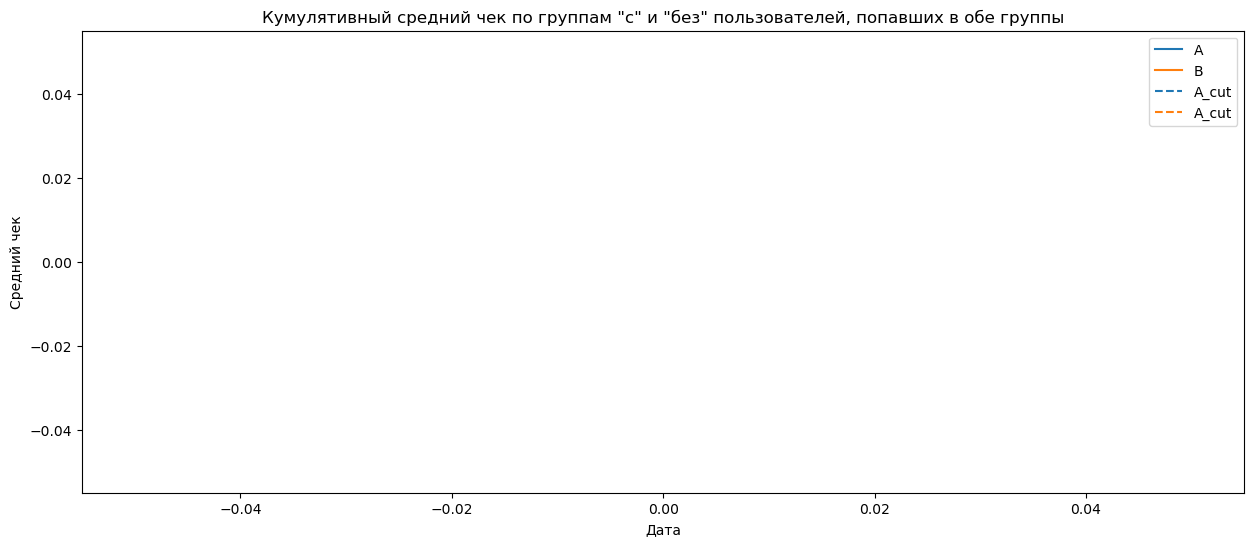

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(cumulative_data_A['date'], cumulative_data_A['revenue']/cumulative_data_A['orders'], label='A', color='C0')
plt.plot(cumulative_data_B['date'], cumulative_data_B['revenue']/cumulative_data_B['orders'], label='B', color='C1')

plt.plot(cumulative_data_A_cut['date'], cumulative_data_A_cut['revenue']/cumulative_data_A_cut['orders'],
         label='A_cut', linestyle='dashed', color='C0')
plt.plot(cumulative_data_B_cut['date'], cumulative_data_B_cut['revenue']/cumulative_data_B_cut['orders'],
         label='A_cut', linestyle='dashed', color='C1')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend()
plt.title('Кумулятивный средний чек по группам "c" и "без" пользователей, попавших в обе группы'); 

Кумулятивный средний чек группы В опережает почти на всем протяжении теста группу А, кроме самого старта и нескольких дней в середине исследования. Так же видим резкий скачок у группы В, который отмечали на прошлом графике.


Отличия между графиками "с" и "без" пользователей, попавших в обе группы - минимальны.

### 2.3 График относительного изменения кумулятивного среднего чека группы B к группе A

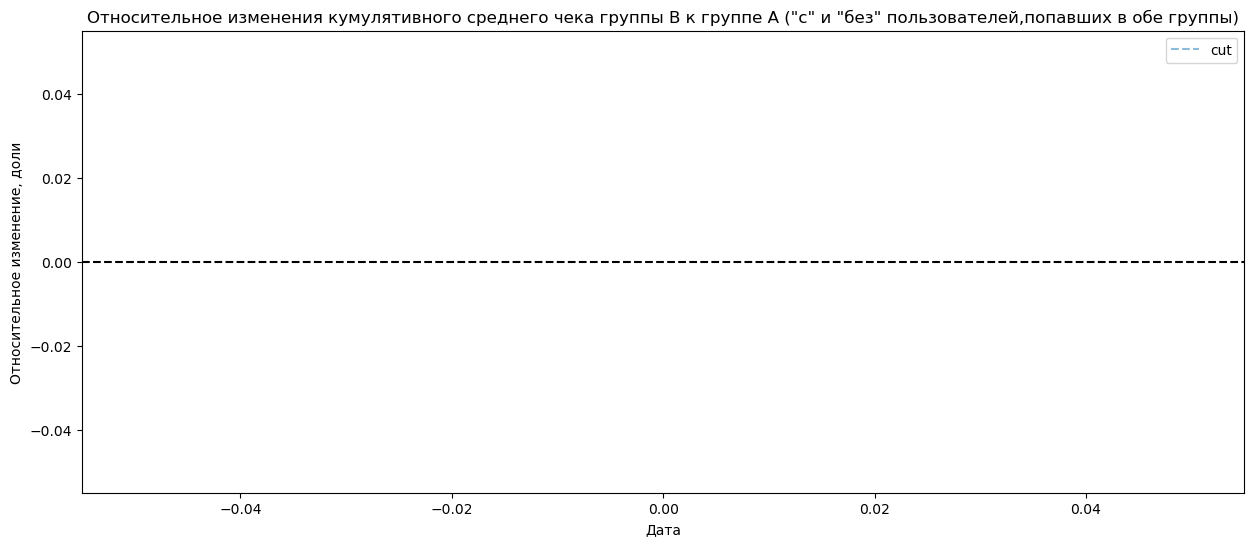

In [18]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_data_A.merge(
    cumulative_data_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15, 6))
plt.plot(merged_cumulative_revenue['date'], \
         (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/
         (merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

# аналогичные операции для дф без пользователей дублеров
merged_cumulative_revenue_cut = cumulative_data_A_cut.merge(
    cumulative_data_B_cut, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue_cut['date'], \
         (merged_cumulative_revenue_cut['revenueB']/merged_cumulative_revenue_cut['ordersB'])/
         (merged_cumulative_revenue_cut['revenueA']/merged_cumulative_revenue_cut['ordersA'])-1, 
         label='cut', color='C0', linestyle='dashed', alpha = 0.5)
plt.xlabel('Дата')
plt.ylabel('Относительное изменение, доли')
plt.legend()
plt.title('Относительное изменения кумулятивного среднего чека группы B к группе A ("с" и "без" пользователей,\
попавших в обе группы)');

На этом графике лучше стали видны отличия, которые не так бросались в глаза на предыдущем графике. Сейчас отчетливо видно, что средний чек группы А был лучше В совсем незначительное время.

Стоит так же отметить, что дальнейший анализ выбросов может существенно изменить поведение графика В между 17 и 21 августа.

Минимальные отличия между графиками "с" и "без" пользователей, попавших в обе группы, сохраняются и на этом графике.

### 2.4 График кумулятивного среднего количества заказов на посетителя по группам


Здесь и далее при расчетах параметров с использованием таблицы visitors показатели без учета пользователей,
попавших в обе группы не рассчитываются, т.к. итоговые значения будут искажены ввиду невозможности исключить пользователей-дублеров из посетителей.

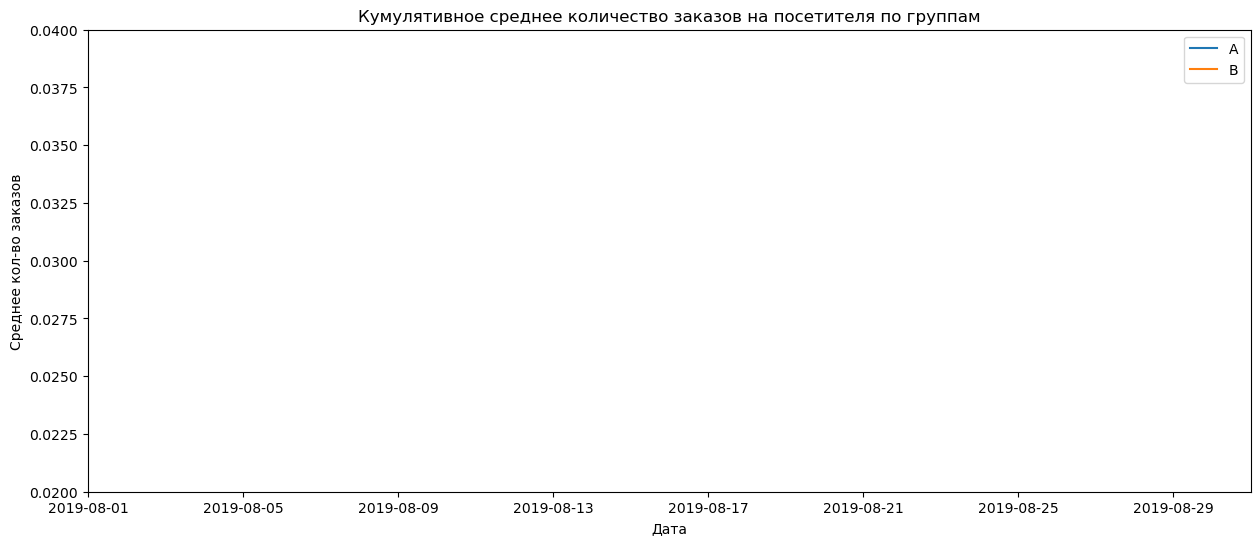

In [19]:
cumulative_A = cumulative_data[cumulative_data['group']=='A']
cumulative_B = cumulative_data[cumulative_data['group']=='B']

# Скрытие ошибки SettingWithCopyWarning
warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)

# преобразуем серии revenue, orders, buyers,visitors в накопленную сумму
cumulative_A[['revenue','orders','buyers','visitors']] = \
                        cumulative_A[['revenue','orders','buyers','visitors']].apply(lambda x: x.cumsum(), axis=0) 
cumulative_B[['revenue','orders','buyers','visitors']] = \
                        cumulative_B[['revenue','orders','buyers','visitors']].apply(lambda x: x.cumsum(), axis=0) 

cumulative_A['conversion'] = cumulative_A['orders']/cumulative_A['visitors']
cumulative_B['conversion'] = cumulative_B['orders']/cumulative_B['visitors']

# строим графики
plt.figure(figsize=(15, 6))
plt.plot(cumulative_A['date'], cumulative_A['conversion'], label='A')
plt.plot(cumulative_B['date'], cumulative_B['conversion'], label='B')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Среднее кол-во заказов')

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0.02, 0.04])
plt.title('Кумулятивное среднее количество заказов на посетителя по группам');

Конверсия группы В была ниже только в начале исследования, в остальные дни пользователи группы В стабильно совершали переход "посетитель-покупатель" чаще. Лучше оценить этот показатель позволит следующий график.

### 2.5 График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

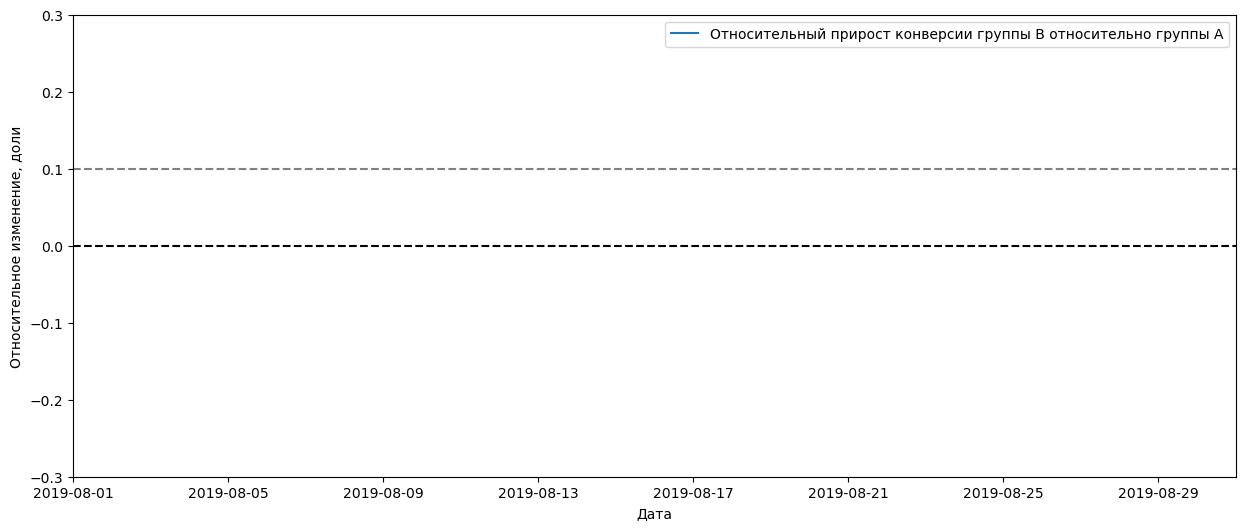

In [20]:
merged_conversions = cumulative_A[['date','conversion']].merge(cumulative_B[['date','conversion']], \
                                                               left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15, 6))
plt.plot(merged_conversions['date'], merged_conversions['conversionB']/merged_conversions['conversionA']-1, \
         label="Относительный прирост конверсии группы B относительно группы A")
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Относительное изменение, доли')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), -0.3, 0.3]);

Первые дни августа конверсия группы А была чуть лучше, затем до 20х чисел августа группа В превышала группу А примерно на 15-20%, к концу месяца превышение вышло на плато в 10%  

### 2.6 График количества заказов на пользователя

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


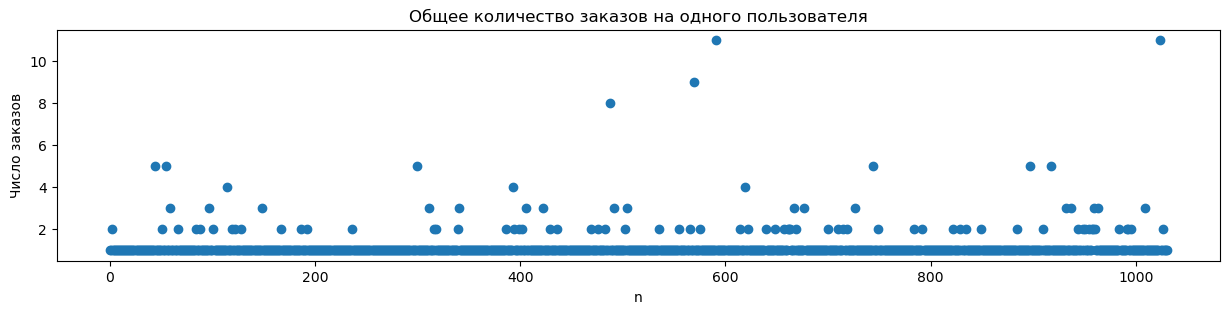

In [21]:
orders_per_user = (orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'}))
orders_per_user.columns = ['userId', 'orders']

# отобразим топ5 пользователей
display(orders_per_user.sort_values(by='orders', ascending=False).head(5))

# серия из чисел от 0 до количества наблюдений в orders_per_user
x_values = pd.Series(range(0, len(orders_per_user)))
plt.figure(figsize=(15, 3))
plt.scatter(x_values, orders_per_user['orders'])
plt.xlabel('n')
plt.ylabel('Число заказов')
plt.title('Общее количество заказов на одного пользователя');

Большее число пользователей имеют по одному заказу, больше 2 заказов - редкость. Есть несколько пользователей-лидеров, которые сделали по 11 заказов. 

Оценим 95-й и 99-й перцентили количества заказов на пользователя.


In [22]:
print(np.percentile(orders_per_user['orders'], [95, 99.0])) 

[2. 4.]


Не более 5% пользователей совершили более 2 заказов и только 1% более 4 заказов.
За границу для определения аномальных пользователей можно выбрать 4 заказа.

### 2.7 График стоимостей заказов

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
682,1216533772,4266935830,2019-08-29,78990,B
662,1811671147,4266935830,2019-08-29,78990,A
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A


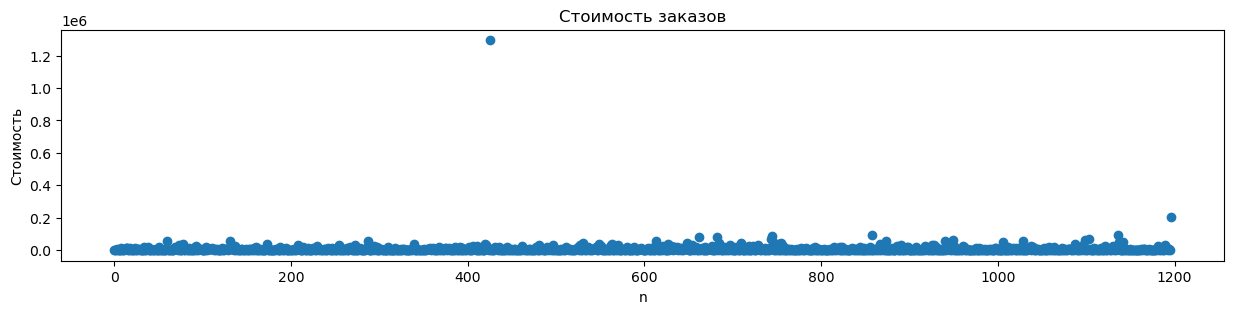

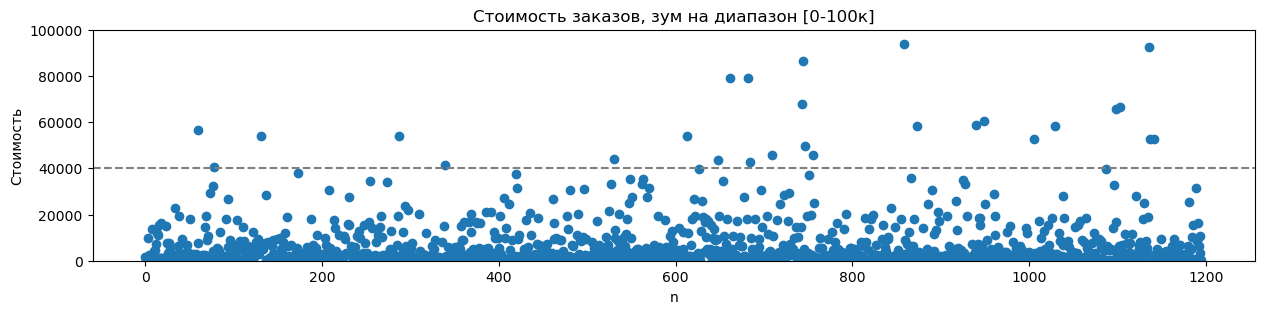

In [23]:
display(orders.sort_values(by='revenue', ascending=False).head(10))

x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(15, 3))
plt.scatter(x_values, orders['revenue'])
plt.xlabel('n')
plt.ylabel('Стоимость')
plt.title('Стоимость заказов');

plt.figure(figsize=(15, 3))
plt.scatter(x_values, orders['revenue'])
plt.xlabel('n')
plt.ylim(0,100000)
plt.axhline(y=40000, color='grey', linestyle='--')
plt.xlabel('n')
plt.ylabel('Стоимость')
plt.title('Стоимость заказов, зум на диапазон [0-100к]');

In [24]:
print(np.percentile(orders['revenue'], [95, 99.0])) 

[28000.  58233.2]


Визуально сумма большинства заказов составляет менее 40 тысяч рублей, что подтверждается расчетом перцентилей, описанных ниже.

Перцентиль 95 показывает, что он равен 28 тысячам и лишь 1% процент заказов дороже 58 тысяч. Лидерский заказ почти на 1.3млн - явный выброс, который вероятно относится к группе и сильно влияет на поведение кумулятивного среднего чека и кумулятивной выручки. За граничное значение возьмем 40 тысяч.

### 2.8 Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Сформулируем гипотезы. Нулевая гипотеза: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.

In [25]:
# считаем накопленное количество посетителей в день в группе А
visitorsA_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsA_daily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsA_daily.apply(lambda x: visitorsA_daily[visitorsA_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1)

visitorsACummulative.columns = ['date', 'visitorsCummulativeA']


# считаем накопленное количество посетителей в день в группе В
visitorsB_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsB_daily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsB_daily.apply(lambda x: visitorsB_daily[visitorsB_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}), axis=1)

visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# считаем накопленную выручку и количество заказов по дня для группы А
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

# считаем накопленую выручку и количество заказов по дня для группы В
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# объединим получившиеся датафреймы
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsA_daily, left_on='date', right_on='date', how='left')
    .merge(visitorsB_daily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

# кол-во заказов на пользователя группы А
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

# кол-во заказов на пользователя группы В 
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

# переменные, в которых пользователям с заказами соответствует число заказов пользователя
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(
    0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(
    0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Расчет статистической значимости различий среднего количества заказов по результатам А/В теста с помощью тест Манна-Уитни, расчет p-value для сравнения среднего между группами



In [26]:
print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

0.01679


Расчет относительного различия в среднем между группами
                                                                                 


In [27]:
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))   

0.138


P-value меньше 0.05, поэтому на сырых данных можно отвергнуть нулевую гипотезу: в среднем количестве заказов между группами есть статистически значимые различия.

Относительный прирост среднего группы В к конверсии группы А равен 13.8%.

### 2.9 Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 

In [28]:
# каждому выводу зададим переменную для дальнейшего общего свода
p1 = ('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                               orders[orders['group']=='B']['revenue'])[1]))
r1 = ('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()
                            /orders[orders['group']=='A']['revenue'].mean()-1)) 
print(p1)
print(r1)

0.729
0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 

Но при этом, средний чек группы B выше чека группы A - на 25.6%. Наблюдаемые различия не являются значимыми при таком уровне значимости, а следовательно, были получены случайно.

Посмотрим, как изменяться показатели после работы с выбросами.

### 2.10 Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

В пункте 2.6 и 2.7 были определены границы для редких значений:

* количество заказов на человека: 4 и более
* максимальная сумма одного заказа: 40 тысяч

Выполним расчет статистической значимости различий в среднем количестве заказов на посетителя между группами без таких пользователей

In [29]:
# фильтрация выбросов
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] >= 4]['userId'], 
        ordersByUsersB[ordersByUsersB['orders'] >= 4]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 40000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)


sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# переменные, в которых пользователям с заказами соответствует число заказов пользователя
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 
print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.00931
0.164


Значения до фильтрации - 0.01679 и 0.138.
После фильтрации P-value по-прежнему меньше 0.05, поэтому отвергаем нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет.

Отфильтрованные данные показывали, что в среднем количестве заказов между группами есть статистически значимые различия: относительный прирост среднего группы В к конверсии группы А равен 16.4%.

Таким образом, конверсия группы действительно имеет значимые улучшения в сравнении с группой А.

### 2.11 Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

In [30]:
p2 = (
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

r2 = (
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 
print(p2)
print(r2)

0.711
0.060


Значения до фильтрации - 0.729 и 0.259.

P-value по-прежнему значительно больше 0.05, соответственно, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.

До фильтрации средний чек группы B выше чека группы A - на 25.6%, после фильтрации - всего 6%.

Таким образом, после фильтрации статистической значимости не появилось, средний чек группы не имеет значимых улучшений в сравнении с группой А. На это указывало p-value до фильтрации, а после фильтрации и отношение прироста среднего чека группы В к чеку группы А.


### 2.12 Проверка влияния пользователей, попавших в обе группы

Выполним расчет всех метрик без пользователей, попавших в обе группы, а затем сведем все полученные данные в один датафрейм

**Расчет статистической значимости различий в среднем количестве заказов без пользователей дублеров до фильтрации выбросов**

In [31]:
# фильтрация дубликатов

sampleA_cut = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(double_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# переменные, в которых пользователям с заказами соответствует число заказов пользователя
sampleB_cut = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(double_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 
print('{0:.5f}'.format(stats.mannwhitneyu(sampleA_cut, sampleB_cut)[1]))
print('{0:.3f}'.format(sampleB_cut.mean()/sampleA_cut.mean()-1)) 

0.01103
0.160


**Расчет статистической значимости различий в среднем количестве заказов без пользователей дублеров с фильтрации выбросов**

In [32]:
# объединим abnormalUsers и double_users
double_plus_abnormal = pd.concat([abnormalUsers, double_users])
double_plus_abnormal = double_plus_abnormal.drop_duplicates()
double_plus_abnormal

1099     148427295
18       199603092
23       237748145
684      358944393
648      382846391
           ...    
51      3963646447
54      3234906277
55         8300375
56      4120364173
57       963407295
Length: 81, dtype: int64

In [33]:
# фильтрация дубликатов

sampleA_cut_filtred = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(double_plus_abnormal))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# переменные, в которых пользователям с заказами соответствует число заказов пользователя
sampleB_cut_filtred = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(double_plus_abnormal))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 
print('{0:.5f}'.format(stats.mannwhitneyu(sampleA_cut_filtred, sampleB_cut_filtred)[1]))
print('{0:.3f}'.format(sampleB_cut_filtred.mean()/sampleA_cut_filtred.mean()-1)) 

0.00622
0.178


**Расчет статистической значимости различий в среднем чеке заказа без пользователей дублеров до фильтрации выбросов**

In [34]:
p3 = (
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(double_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(double_users)),
                )
            ]['revenue'],
        )[1]
    )
)

r3 = (
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(double_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(double_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 
print(p3)
print(r3)

0.829
0.287


**Расчет статистической значимости различий в среднем чеке заказа без пользователей дублеров после фильтрации выбросов**

In [35]:
p4 = (
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(double_plus_abnormal)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(double_plus_abnormal)),
                )
            ]['revenue'],
        )[1]
    )
)

r4 = (
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(double_plus_abnormal)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(double_plus_abnormal)),
            )
        ]['revenue'].mean()
        - 1
    )
) 
print(p4)
print(r4)

0.831
0.051


Соберем результаты в общий датафрейм

In [36]:
# Создание списка словарей с данными
data = [['orders',
         'p-value', 
         ("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1])), 
         ('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1])),
         ('{0:.5f}'.format(stats.mannwhitneyu(sampleA_cut, sampleB_cut)[1])),
         ('{0:.5f}'.format(stats.mannwhitneyu(sampleA_cut_filtred, sampleB_cut_filtred)[1]))],
        ['orders',
         'B-A relation',
         ("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1)),
         ('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) ,
         ('{0:.3f}'.format(sampleB_cut.mean()/sampleA_cut.mean()-1)),
         ('{0:.3f}'.format(sampleB_cut_filtred.mean()/sampleA_cut_filtred.mean()-1)) ],
       ['AOV ',
         'p-value', 
         p1, 
         p2,
         p3,
         p4],
        ['AOV ',
         'B-A relation',
         r1,
         r2,
         r3,
         r4]]
    

# Создание датафрейма из списка списков
results = pd.DataFrame(data, columns=['metric','value', 'raw', 'filtred', 'cut', 'filtred_cut'])
results

,metric,value,raw,filtred,cut,filtred_cut
0,orders,p-value,0.01679,0.00931,0.01103,0.00622
1,orders,B-A relation,0.138,0.164,0.160,0.178
2,AOV,p-value,0.729,0.711,0.829,0.831
3,AOV,B-A relation,0.259,0.060,0.287,0.051


Пользователи, попавшие в обе группы, внесли изменения, но не добавили кардинальных отличий в результаты тестирования в разрезе исследуемых показателей. Как в варианте с фильтрацией выбросов, так и без нее. В целом, показатели группы В еще немного улучшились.

## Выводы

В ходе работы проведена предобработка данных, построено графическое отображение ряда метрик, визуально группа В показывает себя лучше группы А.

Были определены выбивающиеся значения стоимости заказов и количества заказав на одного пользователя, которые далее использовались для фильтрации данных.

Расчеты статистической значимости проведены для следующих вариантов данных: 
* сырых
* фильтрованных от выбросов
* сырых с исключением пользователей, попавших в обе группы данных
* фильтрованных от выбросов и исключением пользователей, попавших в обе группы данных

Наличие 58 пользователей, попавших в обе группы, кардинально не влияет на показатели основных метрик.

Отвергнута нулевая гипотеза: различий в среднем количестве заказов на посетителя между группами нет, p-value менее 0.05.

График различия конверсии между группами указывает на значительно лучшие результаты группы B в сравнении с группой A: от 13.8% на сырых данных до 17.8% с удалением аномальных значений и без учета пользоватлей, которые попали в обе группы. Показатели статистической значимости среднего количества заказов на посетителя подтверждают данный вывод.

Гипотезу "различий в среднем чеке между группами нет" отвергнуть не получилось.
График различия среднего чека колеблется, косвенно указывая на наличие аномалий. При этом, фильтрации выбросов не позволила обнаружить статистически значимых различия по среднему чеку между группами, разница между группами менее 1%.

Таким образом, резюмирую вышеописанное, можно назвать остановить тест, признать его успешным: изменения, предлагаемые пользователям группы В, позволили улучшить среднее количество заказов на посетителя, при этом, не оказав значимого влияния на средний чек.

При проведении дальнейших тестов рекомендуется стараться не допускать попадания пользователей в обе группы исследуемые группы. В данном тесте такие пользователи не оказали критического влияния, но в будущем это может привести пустым тратам и некондиционности А/В теста, если, например, доля таких пользователей будет выше. 